In [126]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import re

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder
from catboost import CatBoostRegressor

pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

In [127]:
df = pd.read_csv("train.csv")
df.head(5)

,patient_id,patient_race,payer_type,patient_state,patient_zip3,Region,Division,patient_age,patient_gender,bmi,breast_cancer_diagnosis_code,breast_cancer_diagnosis_desc,metastatic_cancer_diagnosis_code,metastatic_first_novel_treatment,metastatic_first_novel_treatment_type,population,density,age_median,age_under_10,age_10_to_19,age_20s,age_30s,age_40s,age_50s,age_60s,age_70s,age_over_80,male,female,married,divorced,never_married,widowed,family_size,family_dual_income,income_household_median,income_household_under_5,income_household_5_to_10,income_household_10_to_15,income_household_15_to_20,income_household_20_to_25,income_household_25_to_35,income_household_35_to_50,income_household_50_to_75,income_household_75_to_100,income_household_100_to_150,income_household_150_over,income_household_six_figure,income_individual_median,home_ownership,housing_units,home_value,rent_median,rent_burden,education_less_highschool,education_highschool,education_some_college,education_bachelors,education_graduate,education_college_or_above,education_stem_degree,labor_force_participation,unemployment_rate,self_employed,farmer,race_white,race_black,race_asian,race_native,race_pacific,race_other,race_multiple,hispanic,disabled,poverty,limited_english,commute_time,health_uninsured,veteran,Average of Jan-13,Average of Feb-13,Average of Mar-13,Average of Apr-13,Average of May-13,Average of Jun-13,Average of Jul-13,Average of Aug-13,Average of Sep-13,Average of Oct-13,Average of Nov-13,Average of Dec-13,Average of Jan-14,Average of Feb-14,Average of Mar-14,Average of Apr-14,Average of May-14,Average of Jun-14,Average of Jul-14,Average of Aug-14,Average of Sep-14,Average of Oct-14,Average of Nov-14,Average of Dec-14,Average of Jan-15,Average of Feb-15,Average of Mar-15,Average of Apr-15,Average of May-15,Average of Jun-15,Average of Jul-15,Average of Aug-15,Average of Sep-15,Average of Oct-15,Average of Nov-15,Average of Dec-15,Average of Jan-16,Average of Feb-16,Average of Mar-16,Average of Apr-16,Average of May-16,Average of Jun-16,Average of Jul-16,Average of Aug-16,Average of Sep-16,Average of Oct-16,Average of Nov-16,Average of Dec-16,Average of Jan-17,Average of Feb-17,Average of Mar-17,Average of Apr-17,Average of May-17,Average of Jun-17,Average of Jul-17,Average of Aug-17,Average of Sep-17,Average of Oct-17,Average of Nov-17,Average of Dec-17,Average of Jan-18,Average of Feb-18,Average of Mar-18,Average of Apr-18,Average of May-18,Average of Jun-18,Average of Jul-18,Average of Aug-18,Average of Sep-18,Average of Oct-18,Average of Nov-18,Average of Dec-18,metastatic_diagnosis_period
0,268700,NaN,COMMERCIAL,AR,724,South,West South Central,39,F,NaN,C50912,Malignant neoplasm of unspecified site of left female breast,C773,NaN,NaN,3924.87,82.63,42.58,11.61,13.03,10.87,11.80,12.29,13.22,13.47,10.07,3.64,51.43,48.57,51.05,16.72,23.57,8.66,3.01,43.99,44483.35,2.21,3.97,8.52,7.08,7.67,13.82,15.14,17.51,11.26,8.90,3.93,12.83,24048.55,72.11,1513.75,87384.33,641.39,27.52,16.55,41.83,28.31,9.21,4.11,13.32,38.78,53.60,5.85,11.82,5.31,92.95,1.73,0.33,0.20,0.03,0.83,3.94,3.03,22.24,19.27,0.42,25.35,8.06,8.11,38.55,39.88,42.75,55.16,65.17,75.98,76.75,76.45,73.67,59.73,45.18,37.43,31.67,33.83,42.35,57.72,67.35,75.92,74.28,79.59,70.84,62.39,41.89,41.46,35.24,31.10,45.50,60.94,68.49,77.69,81.35,76.28,73.32,60.32,51.00,48.37,35.76,42.89,53.21,61.07,66.29,82.78,81.52,79.52,75.61,65.76,53.85,39.56,41.59,49.01,52.28,63.40,67.11,75.78,80.58,76.16,72.91,62.68,49.73,39.80,31.71,41.69,50.22,52.55,74.77,79.96,81.69,78.30,74.56,59.98,42.98,41.18,191
1,484983,White,NaN,IL,629,Midwest,East North Central,55,F,35.36,C50412,Malig neoplasm of upper-outer quadrant of left female breast,C773,NaN,NaN,2745.39,51.79,43.54,11.22,12.19,11.45,11.01,11.35,14.39,14.15,9.17,5.05,49.32,50.68,49.48,15.42,26.93,8.17,3.17,41.41,51796.79,3.67,3.86,6.58,5.58,5.38,11.02,13.09,19.56,11.76,11.40,8.11,19.51,28028.04,76.71,1113.35,92026.84,638.60,29.37,10.93,35.26,35.33,12.46,6.04,18.49,36.35,52.51,7.45,9

In [128]:
print(f"Total number of features: {len(df.axes[1])}")

Total number of features: 152


Based on the feature selection performed, the top 15 features are: 'patient_age', 'breast_cancer_diagnosis_desc', 'breast_cancer_diagnosis_code', 'bmi', 'Average of Jun-17', 'education_graduate', 'age_10_to_19', 'patient_zip3', 'commute_time', 'race_native', 'Average of Aug-16', 'income_household_35_to_50', 'divorced', 'Average of Jul-14', 'family_size'

To begin, exploration of null values shall be done.

In [129]:
features = ['patient_age', 'breast_cancer_diagnosis_desc', 'breast_cancer_diagnosis_code', 'bmi', 'Average of Jun-17', 
            'education_graduate', 'age_10_to_19', 'patient_zip3', 'commute_time', 'race_native', 'Average of Aug-16', 
            'income_household_35_to_50', 'divorced', 'Average of Jul-14', 'family_size', 'metastatic_diagnosis_period']
sample = df[features]

## Null Handling

In [130]:
sample.isna().sum()

patient_age                        0
breast_cancer_diagnosis_desc       0
breast_cancer_diagnosis_code       0
bmi                             9071
Average of Jun-17                  1
education_graduate                 0
age_10_to_19                       0
patient_zip3                       0
commute_time                       0
race_native                        0
Average of Aug-16                  0
income_household_35_to_50          5
divorced                           0
Average of Jul-14                  0
family_size                        5
metastatic_diagnosis_period        0
dtype: int64

Four features have missing values: "bmi", "Average of Jun-17", "income_household_35_to_50" and "family_size"

### BMI

A patient's bmi can be a result of several factors such as age, location and socio-economic factors. Given the complexity of imputing bmi values, a tree-based model will be trained and validated to fill missing bmi values.

In [131]:
def imputeBMI(df, drop_columns):

    label_encoder = LabelEncoder()
    df_encoded = df.copy().drop(columns=drop_columns)

    for col in df_encoded.select_dtypes(include=['object']):
        df_encoded[col] = label_encoder.fit_transform(df_encoded[col])

    train_data, val_data = train_test_split(df_encoded.dropna(), test_size=0.2, random_state=42)
    target_data = df_encoded[df_encoded["bmi"].isnull()]

    X_train = train_data.drop(columns='bmi')
    y_train = train_data['bmi']

    X_val = val_data.drop(columns='bmi')
    y_val = val_data['bmi']

    model = CatBoostRegressor(iterations=100, depth=6, learning_rate=0.1, loss_function='RMSE', random_state=42)
    model.fit(X_train, y_train)

    y_val_pred = model.predict(X_val)

    val_rmse = mean_squared_error(y_val, y_val_pred, squared=False)
    print(f"Validation RMSE: {val_rmse}")

    X_target = target_data.drop(columns='bmi')
    y_pred = model.predict(X_target)

    missing_index = df[df['bmi'].isnull()].index
    df.loc[missing_index, 'bmi'] = np.round(y_pred,2)
    return df

In [132]:
remove_cols = ["breast_cancer_diagnosis_desc", "age_10_to_19","race_native", "education_graduate", "divorced", "metastatic_diagnosis_period"]
sample = imputeBMI(sample, remove_cols)

0:	learn: 5.6577635	total: 2.2ms	remaining: 218ms
1:	learn: 5.6436615	total: 3.93ms	remaining: 193ms
2:	learn: 5.6313198	total: 5.59ms	remaining: 181ms
3:	learn: 5.6183511	total: 8.56ms	remaining: 205ms
4:	learn: 5.6030019	total: 11.1ms	remaining: 210ms
5:	learn: 5.5926330	total: 16.1ms	remaining: 252ms
6:	learn: 5.5784980	total: 18.4ms	remaining: 244ms
7:	learn: 5.5658501	total: 20.4ms	remaining: 234ms
8:	learn: 5.5582672	total: 22.2ms	remaining: 225ms
9:	learn: 5.5483431	total: 24.1ms	remaining: 217ms
10:	learn: 5.5409391	total: 26ms	remaining: 211ms
11:	learn: 5.5317307	total: 28.8ms	remaining: 211ms
12:	learn: 5.5225584	total: 31.4ms	remaining: 210ms
13:	learn: 5.5182604	total: 33.2ms	remaining: 204ms
14:	learn: 5.5121291	total: 35.2ms	remaining: 200ms
15:	learn: 5.5087936	total: 36.9ms	remaining: 194ms
16:	learn: 5.5016582	total: 38.8ms	remaining: 189ms
17:	learn: 5.4960980	total: 40.5ms	remaining: 185ms
18:	learn: 5.4842805	total: 42.2ms	remaining: 180ms
19:	learn: 5.4764377	tota

c:\Trisha\CS\DataScience\Equity-in-Healthcare\venv\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


### Average of Jun-17

In [133]:
df[df["Average of Jun-17"].isna()]

,patient_id,patient_race,payer_type,patient_state,patient_zip3,Region,Division,patient_age,patient_gender,bmi,breast_cancer_diagnosis_code,breast_cancer_diagnosis_desc,metastatic_cancer_diagnosis_code,metastatic_first_novel_treatment,metastatic_first_novel_treatment_type,population,density,age_median,age_under_10,age_10_to_19,age_20s,age_30s,age_40s,age_50s,age_60s,age_70s,age_over_80,male,female,married,divorced,never_married,widowed,family_size,family_dual_income,income_household_median,income_household_under_5,income_household_5_to_10,income_household_10_to_15,income_household_15_to_20,income_household_20_to_25,income_household_25_to_35,income_household_35_to_50,income_household_50_to_75,income_household_75_to_100,income_household_100_to_150,income_household_150_over,income_household_six_figure,income_individual_median,home_ownership,housing_units,home_value,rent_median,rent_burden,education_less_highschool,education_highschool,education_some_college,education_bachelors,education_graduate,education_college_or_above,education_stem_degree,labor_force_participation,unemployment_rate,self_employed,farmer,race_white,race_black,race_asian,race_native,race_pacific,race_other,race_multiple,hispanic,disabled,poverty,limited_english,commute_time,health_uninsured,veteran,Average of Jan-13,Average of Feb-13,Average of Mar-13,Average of Apr-13,Average of May-13,Average of Jun-13,Average of Jul-13,Average of Aug-13,Average of Sep-13,Average of Oct-13,Average of Nov-13,Average of Dec-13,Average of Jan-14,Average of Feb-14,Average of Mar-14,Average of Apr-14,Average of May-14,Average of Jun-14,Average of Jul-14,Average of Aug-14,Average of Sep-14,Average of Oct-14,Average of Nov-14,Average of Dec-14,Average of Jan-15,Average of Feb-15,Average of Mar-15,Average of Apr-15,Average of May-15,Average of Jun-15,Average of Jul-15,Average of Aug-15,Average of Sep-15,Average of Oct-15,Average of Nov-15,Average of Dec-15,Average of Jan-16,Average of Feb-16,Average of Mar-16,Average of Apr-16,Average of May-16,Average of Jun-16,Average of Jul-16,Average of Aug-16,Average of Sep-16,Average of Oct-16,Average of Nov-16,Average of Dec-16,Average of Jan-17,Average of Feb-17,Average of Mar-17,Average of Apr-17,Average of May-17,Average of Jun-17,Average of Jul-17,Average of Aug-17,Average of Sep-17,Average of Oct-17,Average of Nov-17,Average of Dec-17,Average of Jan-18,Average of Feb-18,Average of Mar-18,Average of Apr-18,Average of May-18,Average of Jun-18,Average of Jul-18,Average of Aug-18,Average of Sep-18,Average of Oct-18,Average of Nov-18,Average of Dec-18,metastatic_diagnosis_period
12567,241114,NaN,COMMERCIAL,AL,361,South,East South Central,56,F,NaN,C50911,Malignant neoplasm of unsp site of right female breast,C773,NaN,NaN,13044.31,669.67,35.19,12.79,12.77,17.61,15.97,12.66,12.02,8.68,4.94,2.59,57.56,42.44,33.76,15.53,45.81,4.89,3.34,40.17,52875.38,4.14,3.55,5.61,5.16,7.82,10.13,14.19,17.91,11.63,12.75,7.11,19.86,25117.46,40.78,5108.31,108555.7,985.23,33.16,15.59,25.8,31.73,16.11,10.77,26.88,38.99,55.07,7.82,8.98,0.45,35.0,54.33,3.61,0.16,0.06,1.54,5.28,7.81,16.49,19.75,1.05,16.95,9.89,13.04,53.3,51.03,52.38,65.12,70.46,80.57,80.21,80.26,77.18,66.92,53.81,50.96,39.88,50.86,55.55,65.37,72.68,80.83,81.1,82.72,80.1,67.36,50.37,51.52,46.92,45.62,62.36,69.67,74.81,81.95,84.9,82.9,77.2,67.58,62.95,60.09,47.92,54.03,64.16,67.02,73.33,81.82,84.95,84.84,81.77,70.94,60.13,54.41,57.36,59.32,63.77,71.4,75.24,NaN,NaN,81.71,76.6,69.32,59.11,50.53,46.24,65.35,NaN,65.66,77.95,83.85,84.49,83.31,82.68,72.67,56.31,55.01,142


In [134]:
df[df["patient_zip3"]==360]

,patient_id,patient_race,payer_type,patient_state,patient_zip3,Region,Division,patient_age,patient_gender,bmi,breast_cancer_diagnosis_code,breast_cancer_diagnosis_desc,metastatic_cancer_diagnosis_code,metastatic_first_novel_treatment,metastatic_first_novel_treatment_type,population,density,age_median,age_under_10,age_10_to_19,age_20s,age_30s,age_40s,age_50s,age_60s,age_70s,age_over_80,male,female,married,divorced,never_married,widowed,family_size,family_dual_income,income_household_median,income_household_under_5,income_household_5_to_10,income_household_10_to_15,income_household_15_to_20,income_household_20_to_25,income_household_25_to_35,income_household_35_to_50,income_household_50_to_75,income_household_75_to_100,income_household_100_to_150,income_household_150_over,income_household_six_figure,income_individual_median,home_ownership,housing_units,home_value,rent_median,rent_burden,education_less_highschool,education_highschool,education_some_college,education_bachelors,education_graduate,education_college_or_above,education_stem_degree,labor_force_participation,unemployment_rate,self_employed,farmer,race_white,race_black,race_asian,race_native,race_pacific,race_other,race_multiple,hispanic,disabled,poverty,limited_english,commute_time,health_uninsured,veteran,Average of Jan-13,Average of Feb-13,Average of Mar-13,Average of Apr-13,Average of May-13,Average of Jun-13,Average of Jul-13,Average of Aug-13,Average of Sep-13,Average of Oct-13,Average of Nov-13,Average of Dec-13,Average of Jan-14,Average of Feb-14,Average of Mar-14,Average of Apr-14,Average of May-14,Average of Jun-14,Average of Jul-14,Average of Aug-14,Average of Sep-14,Average of Oct-14,Average of Nov-14,Average of Dec-14,Average of Jan-15,Average of Feb-15,Average of Mar-15,Average of Apr-15,Average of May-15,Average of Jun-15,Average of Jul-15,Average of Aug-15,Average of Sep-15,Average of Oct-15,Average of Nov-15,Average of Dec-15,Average of Jan-16,Average of Feb-16,Average of Mar-16,Average of Apr-16,Average of May-16,Average of Jun-16,Average of Jul-16,Average of Aug-16,Average of Sep-16,Average of Oct-16,Average of Nov-16,Average of Dec-16,Average of Jan-17,Average of Feb-17,Average of Mar-17,Average of Apr-17,Average of May-17,Average of Jun-17,Average of Jul-17,Average of Aug-17,Average of Sep-17,Average of Oct-17,Average of Nov-17,Average of Dec-17,Average of Jan-18,Average of Feb-18,Average of Mar-18,Average of Apr-18,Average of May-18,Average of Jun-18,Average of Jul-18,Average of Aug-18,Average of Sep-18,Average of Oct-18,Average of Nov-18,Average of Dec-18,metastatic_diagnosis_period
5779,487463,NaN,COMMERCIAL,AL,360,South,East South Central,66,F,NaN,C50811,Malignant neoplasm of ovrlp sites of right female breast,C773,NaN,NaN,5269.75,62.15,41.68,9.43,14.44,13.05,11.97,11.7,13.55,13.2,8.91,3.76,50.17,49.83,43.21,14.36,35.21,7.21,3.39,43.42,52677.64,4.1,3.83,6.79,6.3,5.22,11.31,13.33,16.6,11.8,12.23,8.49,20.72,25699.43,77.6,1896.95,178127.4,754.11,31.3,15.19,38.38,27.59,11.93,6.9,18.83,41.32,49.69,5.39,11.12,5.03,57.04,38.89,0.81,0.37,0.01,0.53,2.34,2.23,18.5,16.25,0.53,28.89,11.01,7.65,53.03,50.32,51.73,64.48,69.8,79.82,79.37,79.42,76.42,66.32,53.5,50.62,39.39,50.32,54.68,64.58,71.91,79.91,80.13,81.73,78.96,66.73,50.03,51.24,46.33,44.64,61.35,68.71,73.94,80.95,83.67,81.97,76.2,67.15,61.74,59.1,46.56,52.66,62.85,66.24,72.29,80.91,83.91,83.66,80.6,69.9,59.1,54.73,55.69,58.11,61.94,69.91,73.6,75.52,79.99,80.8,75.61,68.3,57.98,49.83,44.82,63.61,56.24,63.94,76.63,82.23,83.15,82.01,81.76,71.27,54.96,53.36,302
8073,483087,NaN,COMMERCIAL,AL,360,South,East South Central,62,F,NaN,1749,"Malignant neoplasm of breast (female), unspecified",C787,NaN,NaN,5269.75,62.15,41.68,9.43,14.44,13.05,11.97,11.7,13.55,13.2,8.91,3.76,50.17,49.83,43.21,14.36,35.21,7.21,3.39,43.42,52677.64,4.1,3.83,6.79,6.3,5.22,11.31,13.33,16.6,11.8,12.23,8.49,20.72,25699.43,77.6,1896.95,178127.4,754.11,31.3,15.19,38.38,27.59,11.93,6.9,18.83,41.32,49.69,5.39,11.12,5.03,57.04,38.89,0.81,0.37,0.0

The patient with a missing temperature value is the only reprentative for their zip3 code (361). This patient belongs to Alabama. Upon inspecting zip3 codes close to 361, 360 is the closest and shares similar temperatures with the patient in 361. Thus, the values for 360 will be used for 361.

In [135]:
sample.loc[sample["patient_zip3"] == 361, "Average of Jun-17"] = sample[sample["patient_zip3"] == 360]["Average of Jun-17"].iloc[0]

### income_household_35_to_50 and family_size

In [136]:
df[df["income_household_35_to_50"].isna()]

,patient_id,patient_race,payer_type,patient_state,patient_zip3,Region,Division,patient_age,patient_gender,bmi,breast_cancer_diagnosis_code,breast_cancer_diagnosis_desc,metastatic_cancer_diagnosis_code,metastatic_first_novel_treatment,metastatic_first_novel_treatment_type,population,density,age_median,age_under_10,age_10_to_19,age_20s,age_30s,age_40s,age_50s,age_60s,age_70s,age_over_80,male,female,married,divorced,never_married,widowed,family_size,family_dual_income,income_household_median,income_household_under_5,income_household_5_to_10,income_household_10_to_15,income_household_15_to_20,income_household_20_to_25,income_household_25_to_35,income_household_35_to_50,income_household_50_to_75,income_household_75_to_100,income_household_100_to_150,income_household_150_over,income_household_six_figure,income_individual_median,home_ownership,housing_units,home_value,rent_median,rent_burden,education_less_highschool,education_highschool,education_some_college,education_bachelors,education_graduate,education_college_or_above,education_stem_degree,labor_force_participation,unemployment_rate,self_employed,farmer,race_white,race_black,race_asian,race_native,race_pacific,race_other,race_multiple,hispanic,disabled,poverty,limited_english,commute_time,health_uninsured,veteran,Average of Jan-13,Average of Feb-13,Average of Mar-13,Average of Apr-13,Average of May-13,Average of Jun-13,Average of Jul-13,Average of Aug-13,Average of Sep-13,Average of Oct-13,Average of Nov-13,Average of Dec-13,Average of Jan-14,Average of Feb-14,Average of Mar-14,Average of Apr-14,Average of May-14,Average of Jun-14,Average of Jul-14,Average of Aug-14,Average of Sep-14,Average of Oct-14,Average of Nov-14,Average of Dec-14,Average of Jan-15,Average of Feb-15,Average of Mar-15,Average of Apr-15,Average of May-15,Average of Jun-15,Average of Jul-15,Average of Aug-15,Average of Sep-15,Average of Oct-15,Average of Nov-15,Average of Dec-15,Average of Jan-16,Average of Feb-16,Average of Mar-16,Average of Apr-16,Average of May-16,Average of Jun-16,Average of Jul-16,Average of Aug-16,Average of Sep-16,Average of Oct-16,Average of Nov-16,Average of Dec-16,Average of Jan-17,Average of Feb-17,Average of Mar-17,Average of Apr-17,Average of May-17,Average of Jun-17,Average of Jul-17,Average of Aug-17,Average of Sep-17,Average of Oct-17,Average of Nov-17,Average of Dec-17,Average of Jan-18,Average of Feb-18,Average of Mar-18,Average of Apr-18,Average of May-18,Average of Jun-18,Average of Jul-18,Average of Aug-18,Average of Sep-18,Average of Oct-18,Average of Nov-18,Average of Dec-18,metastatic_diagnosis_period
3985,757384,NaN,COMMERCIAL,TX,772,South,West South Central,43,F,28.0,C50911,Malignant neoplasm of unsp site of right female breast,C773,NaN,NaN,4459.0,3376.1,20.6,0.0,35.3,62.1,1.5,0.8,0.0,0.2,0.0,0.0,47.1,52.9,0.9,0.2,98.9,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4316.0,NaN,0.0,NaN,NaN,NaN,0.0,0.0,44.8,41.7,13.5,55.2,73.0,30.7,18.8,NaN,NaN,47.6,23.0,20.1,0.0,0.0,1.7,7.6,18.2,4.6,NaN,NaN,16.2,4.5,1.6,52.36,56.4,59.25,66.05,73.87,82.56,82.95,84.99,81.4,70.52,56.23,49.51,47.31,53.35,57.7,67.66,73.92,84.1,82.81,83.57,79.69,71.54,56.36,55.84,49.87,51.02,59.94,71.24,74.85,80.84,85.18,84.81,80.69,73.54,62.15,58.43,51.56,58.81,64.94,69.85,75.39,82.04,87.24,83.8,82.73,75.83,67.04,56.38,58.15,65.85,67.7,71.45,75.51,81.86,85.63,83.71,79.54,70.17,65.8,51.79,46.29,57.91,66.5,65.66,79.57,84.9,85.55,85.06,80.93,71.28,56.46,53.85,40
4404,367375,NaN,COMMERCIAL,TX,772,South,West South Central,61,F,33.1,1743,Malignant neoplasm of lower-inner quadrant of female breast,C7951,NaN,NaN,4459.0,3376.1,20.6,0.0,35.3,62.1,1.5,0.8,0.0,0.2,0.0,0.0,47.1,52.9,0.9,0.2,98.9,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4316.0,NaN,0.0,NaN,NaN,NaN,0.0,0.0,44.8,41.7,13.5,55.2,73.0,30.7,18.8,NaN,NaN,47.6,23.0,20.1,0.0,0.0,1.7,7.6,18.2,4.6,NaN,NaN,16.2,4.5,1.6,52.36,56.4,59.25,66.05,73.87,82.56,82.95,84.99,81.4,70.52,56.23,49.51,47.31,53.35,57.7,67.66,73.92,84.1,82.8

In [137]:
df[df["family_size"].isna()]

,patient_id,patient_race,payer_type,patient_state,patient_zip3,Region,Division,patient_age,patient_gender,bmi,breast_cancer_diagnosis_code,breast_cancer_diagnosis_desc,metastatic_cancer_diagnosis_code,metastatic_first_novel_treatment,metastatic_first_novel_treatment_type,population,density,age_median,age_under_10,age_10_to_19,age_20s,age_30s,age_40s,age_50s,age_60s,age_70s,age_over_80,male,female,married,divorced,never_married,widowed,family_size,family_dual_income,income_household_median,income_household_under_5,income_household_5_to_10,income_household_10_to_15,income_household_15_to_20,income_household_20_to_25,income_household_25_to_35,income_household_35_to_50,income_household_50_to_75,income_household_75_to_100,income_household_100_to_150,income_household_150_over,income_household_six_figure,income_individual_median,home_ownership,housing_units,home_value,rent_median,rent_burden,education_less_highschool,education_highschool,education_some_college,education_bachelors,education_graduate,education_college_or_above,education_stem_degree,labor_force_participation,unemployment_rate,self_employed,farmer,race_white,race_black,race_asian,race_native,race_pacific,race_other,race_multiple,hispanic,disabled,poverty,limited_english,commute_time,health_uninsured,veteran,Average of Jan-13,Average of Feb-13,Average of Mar-13,Average of Apr-13,Average of May-13,Average of Jun-13,Average of Jul-13,Average of Aug-13,Average of Sep-13,Average of Oct-13,Average of Nov-13,Average of Dec-13,Average of Jan-14,Average of Feb-14,Average of Mar-14,Average of Apr-14,Average of May-14,Average of Jun-14,Average of Jul-14,Average of Aug-14,Average of Sep-14,Average of Oct-14,Average of Nov-14,Average of Dec-14,Average of Jan-15,Average of Feb-15,Average of Mar-15,Average of Apr-15,Average of May-15,Average of Jun-15,Average of Jul-15,Average of Aug-15,Average of Sep-15,Average of Oct-15,Average of Nov-15,Average of Dec-15,Average of Jan-16,Average of Feb-16,Average of Mar-16,Average of Apr-16,Average of May-16,Average of Jun-16,Average of Jul-16,Average of Aug-16,Average of Sep-16,Average of Oct-16,Average of Nov-16,Average of Dec-16,Average of Jan-17,Average of Feb-17,Average of Mar-17,Average of Apr-17,Average of May-17,Average of Jun-17,Average of Jul-17,Average of Aug-17,Average of Sep-17,Average of Oct-17,Average of Nov-17,Average of Dec-17,Average of Jan-18,Average of Feb-18,Average of Mar-18,Average of Apr-18,Average of May-18,Average of Jun-18,Average of Jul-18,Average of Aug-18,Average of Sep-18,Average of Oct-18,Average of Nov-18,Average of Dec-18,metastatic_diagnosis_period
3985,757384,NaN,COMMERCIAL,TX,772,South,West South Central,43,F,28.0,C50911,Malignant neoplasm of unsp site of right female breast,C773,NaN,NaN,4459.0,3376.1,20.6,0.0,35.3,62.1,1.5,0.8,0.0,0.2,0.0,0.0,47.1,52.9,0.9,0.2,98.9,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4316.0,NaN,0.0,NaN,NaN,NaN,0.0,0.0,44.8,41.7,13.5,55.2,73.0,30.7,18.8,NaN,NaN,47.6,23.0,20.1,0.0,0.0,1.7,7.6,18.2,4.6,NaN,NaN,16.2,4.5,1.6,52.36,56.4,59.25,66.05,73.87,82.56,82.95,84.99,81.4,70.52,56.23,49.51,47.31,53.35,57.7,67.66,73.92,84.1,82.81,83.57,79.69,71.54,56.36,55.84,49.87,51.02,59.94,71.24,74.85,80.84,85.18,84.81,80.69,73.54,62.15,58.43,51.56,58.81,64.94,69.85,75.39,82.04,87.24,83.8,82.73,75.83,67.04,56.38,58.15,65.85,67.7,71.45,75.51,81.86,85.63,83.71,79.54,70.17,65.8,51.79,46.29,57.91,66.5,65.66,79.57,84.9,85.55,85.06,80.93,71.28,56.46,53.85,40
4404,367375,NaN,COMMERCIAL,TX,772,South,West South Central,61,F,33.1,1743,Malignant neoplasm of lower-inner quadrant of female breast,C7951,NaN,NaN,4459.0,3376.1,20.6,0.0,35.3,62.1,1.5,0.8,0.0,0.2,0.0,0.0,47.1,52.9,0.9,0.2,98.9,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4316.0,NaN,0.0,NaN,NaN,NaN,0.0,0.0,44.8,41.7,13.5,55.2,73.0,30.7,18.8,NaN,NaN,47.6,23.0,20.1,0.0,0.0,1.7,7.6,18.2,4.6,NaN,NaN,16.2,4.5,1.6,52.36,56.4,59.25,66.05,73.87,82.56,82.95,84.99,81.4,70.52,56.23,49.51,47.31,53.35,57.7,67.66,73.92,84.1,82.8

In [138]:
missing_income = len(df[df["income_household_35_to_50"].isna()])/len(df.axes[0])
print(f"% of missing values for income_household_35_to_50 is {round(missing_income*100,2)}")

missing_size = len(df[df["family_size"].isna()])/len(df.axes[0])
print(f"% of missing values for family_size is {round(missing_size*100,2)}")

% of missing values for income_household_35_to_50 is 0.04
% of missing values for family_size is 0.04


Based on the above, besides income_household_35_to_50 and family_size, several other income and home data points are missing information. This could imply that information for this particular patient_zip3 was not entered. Since the amount of missing points for these features is negligible, the rows with missing income_household_35_to_50/family_size values will be dropped.

In [139]:
sample.dropna(subset=["income_household_35_to_50"], inplace=True)

C:\Users\indiv\AppData\Local\Temp\ipykernel_12356\1538942276.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sample.dropna(subset=["income_household_35_to_50"], inplace=True)


In [140]:
# Check if all nan values have been resolved
sample.isna().sum()

patient_age                     0
breast_cancer_diagnosis_desc    0
breast_cancer_diagnosis_code    0
bmi                             0
Average of Jun-17               0
education_graduate              0
age_10_to_19                    0
patient_zip3                    0
commute_time                    0
race_native                     0
Average of Aug-16               0
income_household_35_to_50       0
divorced                        0
Average of Jul-14               0
family_size                     0
metastatic_diagnosis_period     0
dtype: int64

## Data Cleaning

Now that missing values have been addressed, each feature shall be explored to determine if there are any issues with the data and fix the same.

### patient_age

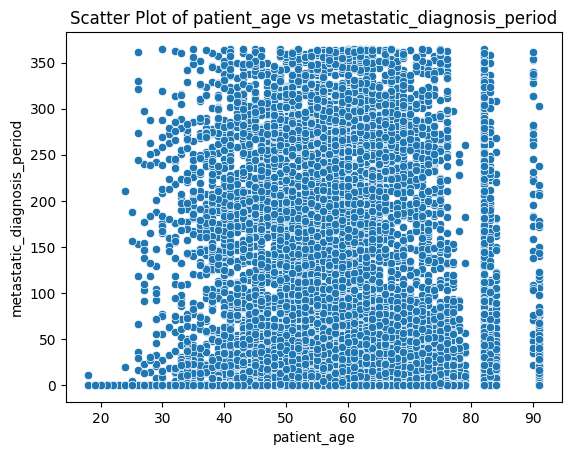

In [141]:
sns.scatterplot(x='patient_age', y='metastatic_diagnosis_period', data=sample)
plt.xlabel('patient_age')
plt.ylabel('metastatic_diagnosis_period')
plt.title('Scatter Plot of patient_age vs metastatic_diagnosis_period')
plt.show()

Below, age is grouped to determine if model performance improves.

In [142]:
bins = [0, 20, 30, 40, 50, 60, 70, 80, 90, 100,float('inf')]
labels = ['<20', '21-30', '31-40', '41-50', '51-60', '61-70', '71-80', '81-90', '91-100', "100+"]

# Create age_group column
sample.loc[:, 'age_group'] = pd.cut(sample['patient_age'], bins=bins, labels=labels, right=False)

C:\Users\indiv\AppData\Local\Temp\ipykernel_12356\362120130.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sample.loc[:, 'age_group'] = pd.cut(sample['patient_age'], bins=bins, labels=labels, right=False)


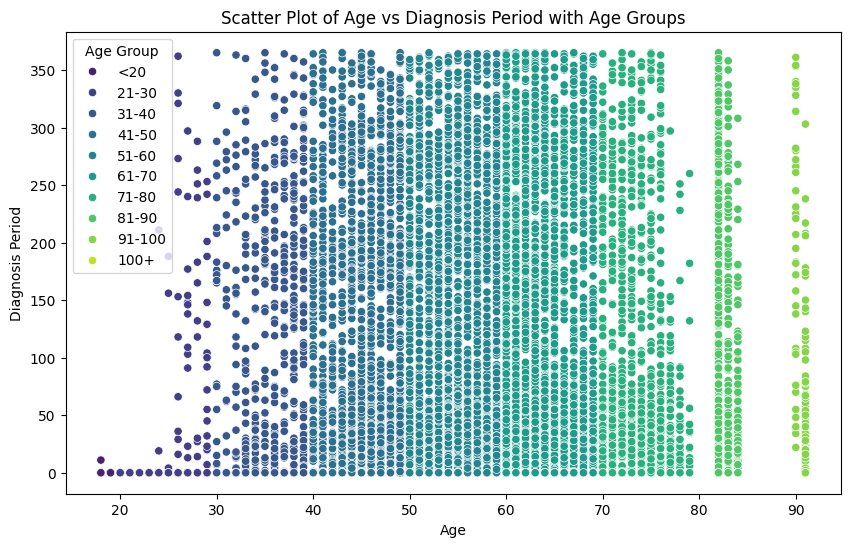

In [143]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='patient_age', y='metastatic_diagnosis_period', hue='age_group', data=sample, palette='viridis')
plt.xlabel('Age')
plt.ylabel('Diagnosis Period')
plt.title('Scatter Plot of Age vs Diagnosis Period with Age Groups')
plt.legend(title='Age Group')
plt.show()

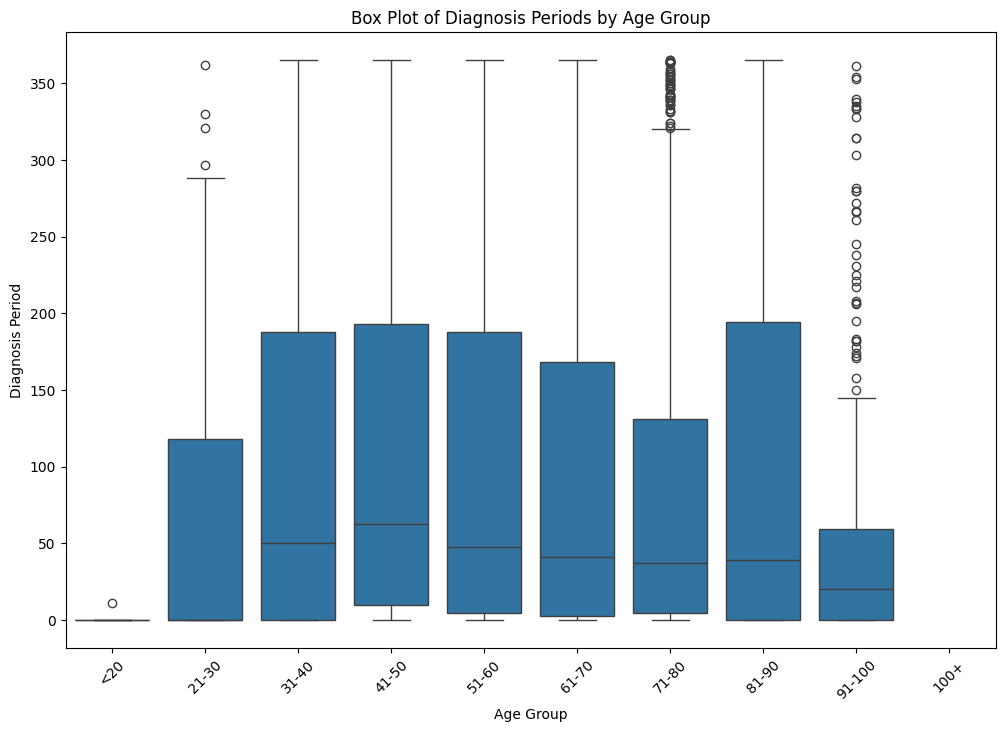

In [144]:
plt.figure(figsize=(12, 8))
sns.boxplot(x='age_group', y='metastatic_diagnosis_period', data=sample)
plt.xlabel('Age Group')
plt.ylabel('Diagnosis Period')
plt.title('Box Plot of Diagnosis Periods by Age Group')
plt.xticks(rotation=45)
plt.show()

In [145]:
#Remove patient_age from sample

sample = sample.drop(columns=["patient_age"])

### breast_cancer_diagnosis_desc + code

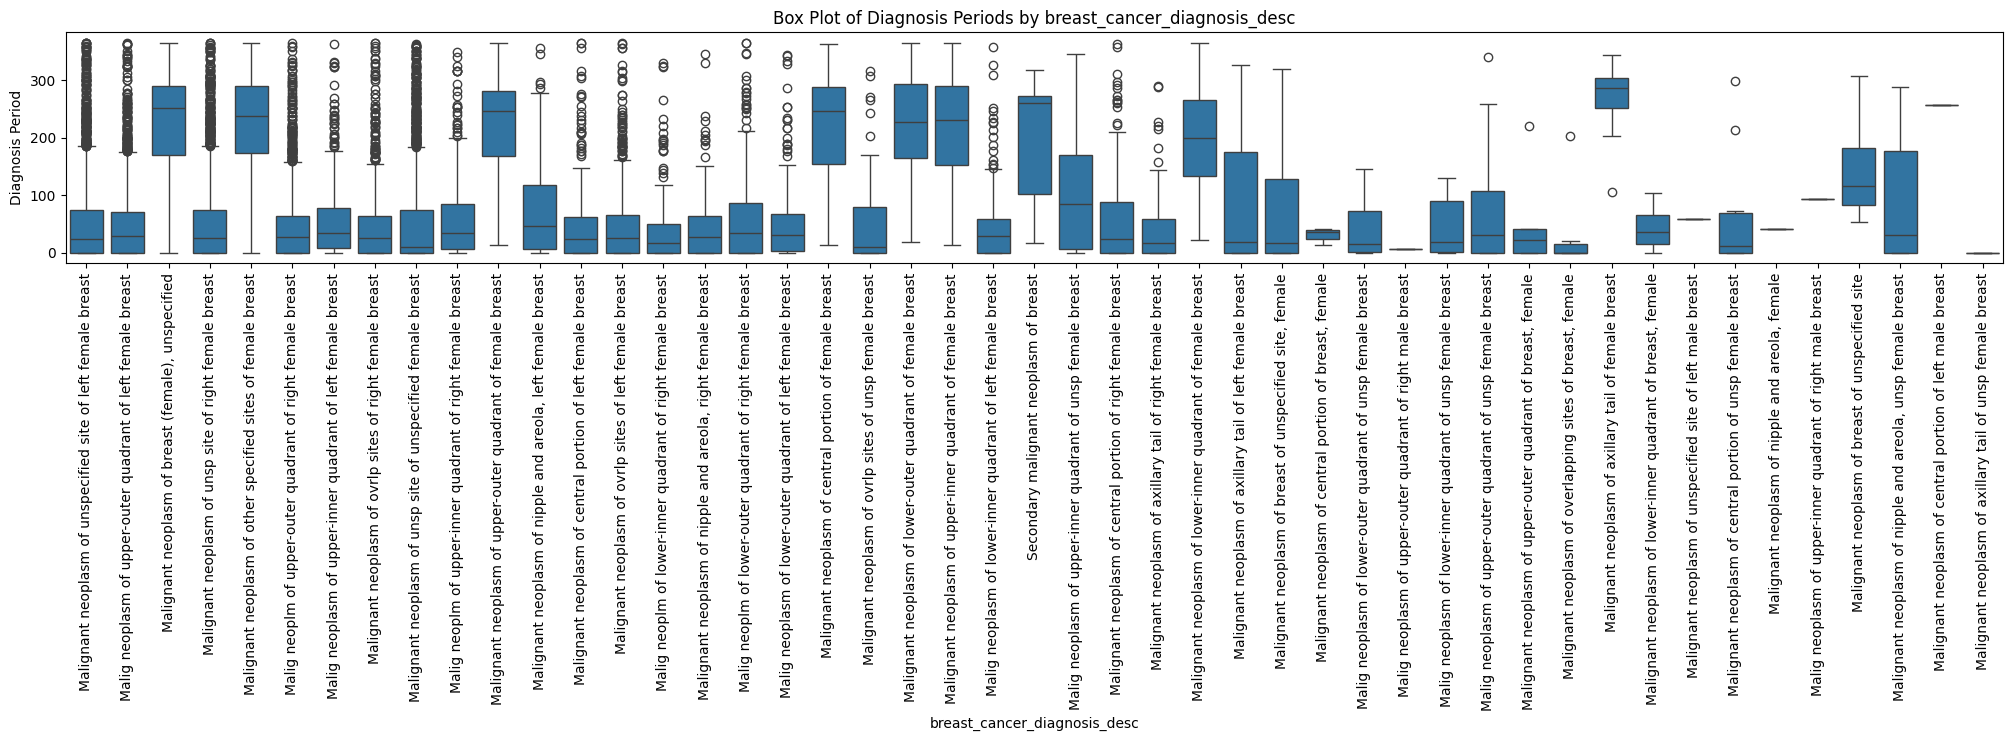

In [146]:
plt.figure(figsize=(25,3))
sns.boxplot(x='breast_cancer_diagnosis_desc', y='metastatic_diagnosis_period', data=sample)
plt.xlabel('breast_cancer_diagnosis_desc')
plt.ylabel('Diagnosis Period')
plt.title('Box Plot of Diagnosis Periods by breast_cancer_diagnosis_desc')
plt.xticks(rotation=90)
plt.show()

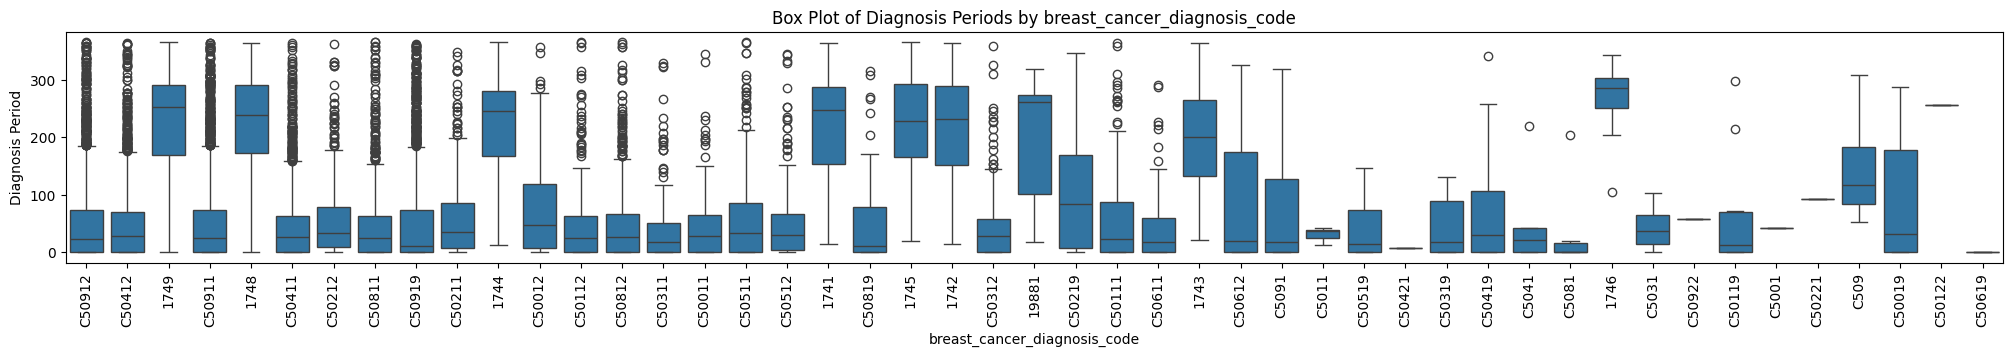

In [147]:
plt.figure(figsize=(25,3))
sns.boxplot(x='breast_cancer_diagnosis_code', y='metastatic_diagnosis_period', data=sample)
plt.xlabel('breast_cancer_diagnosis_code')
plt.ylabel('Diagnosis Period')
plt.title('Box Plot of Diagnosis Periods by breast_cancer_diagnosis_code')
plt.xticks(rotation=90)
plt.show()

In [148]:
# Check if every code has a unique description

def uniquenessCheck(df,col1,col2):
    result_dict = {}
    for key, value in zip(df[col1], df[col2]):
        if key not in result_dict:
            result_dict[key] = []
        if value not in result_dict[key]:
            result_dict[key].append(value)

    for key, values in result_dict.items():
        if len(values) > 1:
            print(f"{key}: {values}")
    print("Check done.")

    return result_dict

code_to_desc = uniquenessCheck(sample,"breast_cancer_diagnosis_code","breast_cancer_diagnosis_desc")
desc_to_code = uniquenessCheck(sample,"breast_cancer_diagnosis_desc","breast_cancer_diagnosis_code")

Check done.
Check done.


Each code has it's own description. Let's explore them in parallel.

In [149]:
print(f"Number of unique codes is {len(code_to_desc)}")

Number of unique codes is 47


In [150]:
keys = []
values = []
for key, value in code_to_desc.items():
    keys.append(key)
    values.append(value[0])


code_desc = pd.DataFrame({
    "Code":keys,
    "Desc":values
})

After a search online, codes that begin with C or D are ICD-10 codes for neoplasms. Additionally, to verify that the codes have been entered correctly, ICD-9 codes have a length of 3-5 digits while ICD-10 have a length of 3-7 digits. This information will be used to distinguish and verify the codes in the dataset-a column will be created that identifies the type of code to aid feature understanding and improve performance.

In [151]:
#Assignment of ICD-9 and ICD-10 codes
def assign_icd_codes(df, column_name):
    def assign_icd_code(value):
        if str(value).startswith('C') or str(value).startswith('D'):
            return 'ICD-10'
        else:
            return 'ICD-9'

    df['ICD_code'] = df[column_name].apply(assign_icd_code)
    return df

sample = assign_icd_codes(sample, 'breast_cancer_diagnosis_code')
code_desc = assign_icd_codes(code_desc, 'Code')

In [152]:
#Check to ensure data contains accurate code lenghts
def check_and_print(df):
    for index, row in df.iterrows():
        code = row['Code']
        icd_code = row['ICD_code']
        if icd_code == 'ICD_10':
            if len(code) < 3 or len(code) > 7:
                print(code)
        elif icd_code == 'ICD_9':
            if len(code) < 3 or len(code) > 5:
                print(code)

check_and_print(code_desc)

All codes seem to be accurately typed in terms of length. However, some descriptions have "male" written. Given that the original dataframe has "F" for all values in the column patient_gender, it may be that the male version of a similar code could have been accidentally entered. The below works on checking if this is a data entry issue.

In [154]:
# Let's first standardize all descriptions
# Change all Malig->Malignant, neoplm ->neoplasm, unsp->unspecified (for codes), ovrlp->overlapping 

def replace_words(df, column_name):
    replacements = {
        r'\bMalig\b': 'Malignant',
        r'\bneoplm\b': 'neoplasm',
        r'\bunsp\b': 'unspecified',
        r'\bovrlp\b': 'overlapping'
    }
    
    def replace_in_string(text):
        for pattern, replacement in replacements.items():
            text = re.sub(pattern, replacement, text)
        return text
    
    df[column_name] = df[column_name].apply(replace_in_string)
    
    return df

code_desc = replace_words(code_desc, "Desc")
sample = replace_words(sample, "breast_cancer_diagnosis_desc")

In [163]:
# Let's check if patient_gender is an accident by looking at the number of rows that contain "male" in breast_cancer_diagnosis_desc

df[df['breast_cancer_diagnosis_desc'].str.contains(r'\bmale\b', case=False, na=False)]

,patient_id,patient_race,payer_type,patient_state,patient_zip3,Region,Division,patient_age,patient_gender,bmi,breast_cancer_diagnosis_code,breast_cancer_diagnosis_desc,metastatic_cancer_diagnosis_code,metastatic_first_novel_treatment,metastatic_first_novel_treatment_type,population,density,age_median,age_under_10,age_10_to_19,age_20s,age_30s,age_40s,age_50s,age_60s,age_70s,age_over_80,male,female,married,divorced,never_married,widowed,family_size,family_dual_income,income_household_median,income_household_under_5,income_household_5_to_10,income_household_10_to_15,income_household_15_to_20,income_household_20_to_25,income_household_25_to_35,income_household_35_to_50,income_household_50_to_75,income_household_75_to_100,income_household_100_to_150,income_household_150_over,income_household_six_figure,income_individual_median,home_ownership,housing_units,home_value,rent_median,rent_burden,education_less_highschool,education_highschool,education_some_college,education_bachelors,education_graduate,education_college_or_above,education_stem_degree,labor_force_participation,unemployment_rate,self_employed,farmer,race_white,race_black,race_asian,race_native,race_pacific,race_other,race_multiple,hispanic,disabled,poverty,limited_english,commute_time,health_uninsured,veteran,Average of Jan-13,Average of Feb-13,Average of Mar-13,Average of Apr-13,Average of May-13,Average of Jun-13,Average of Jul-13,Average of Aug-13,Average of Sep-13,Average of Oct-13,Average of Nov-13,Average of Dec-13,Average of Jan-14,Average of Feb-14,Average of Mar-14,Average of Apr-14,Average of May-14,Average of Jun-14,Average of Jul-14,Average of Aug-14,Average of Sep-14,Average of Oct-14,Average of Nov-14,Average of Dec-14,Average of Jan-15,Average of Feb-15,Average of Mar-15,Average of Apr-15,Average of May-15,Average of Jun-15,Average of Jul-15,Average of Aug-15,Average of Sep-15,Average of Oct-15,Average of Nov-15,Average of Dec-15,Average of Jan-16,Average of Feb-16,Average of Mar-16,Average of Apr-16,Average of May-16,Average of Jun-16,Average of Jul-16,Average of Aug-16,Average of Sep-16,Average of Oct-16,Average of Nov-16,Average of Dec-16,Average of Jan-17,Average of Feb-17,Average of Mar-17,Average of Apr-17,Average of May-17,Average of Jun-17,Average of Jul-17,Average of Aug-17,Average of Sep-17,Average of Oct-17,Average of Nov-17,Average of Dec-17,Average of Jan-18,Average of Feb-18,Average of Mar-18,Average of Apr-18,Average of May-18,Average of Jun-18,Average of Jul-18,Average of Aug-18,Average of Sep-18,Average of Oct-18,Average of Nov-18,Average of Dec-18,metastatic_diagnosis_period
712,133511,NaN,COMMERCIAL,PA,173,Northeast,Middle Atlantic,45,F,NaN,C50421,Malig neoplasm of upper-outer quadrant of right male breast,C773,NaN,NaN,7218.35,279.90,43.69,10.55,12.56,11.21,11.34,13.05,15.23,14.32,7.63,4.10,51.38,48.62,54.89,13.45,26.35,5.31,3.00,58.32,77876.83,1.29,1.11,2.37,3.11,2.85,6.91,12.12,18.37,17.11,21.79,12.96,34.75,37291.81,79.85,2817.81,207139.9,1004.98,26.91,9.44,42.56,25.05,15.40,7.57,22.96,42.78,67.35,3.77,8.81,1.50,93.24,1.51,0.48,0.11,0.01,1.74,2.91,5.15,12.77,6.02,0.83,29.18,5.26,7.50,33.19,31.42,38.06,52.65,61.24,71.46,76.93,71.24,64.76,56.30,41.41,35.09,23.69,27.98,34.61,50.72,62.21,71.05,73.86,70.25,66.38,56.58,40.64,37.48,27.30,21.77,36.07,52.68,67.03,71.17,74.10,72.79,69.15,53.38,48.80,45.36,29.01,33.39,46.73,50.90,59.62,71.17,77.23,76.81,70.20,57.18,45.98,35.06,34.83,40.63,38.94,57.06,59.95,71.57,76.05,70.98,66.89,59.56,42.89,32.68,27.80,37.49,36.78,47.55,66.70,70.40,75.45,75.67,69.69,56.51,40.45,36.92,7
1908,141903,Other,MEDICAID,FL,330,South,South Atlantic,66,F,24.0,C50922,Malignant neoplasm of unspecified site of left male breast,C7981,NaN,NaN,34958.92,1716.93,43.38,10.63,11.39,11.20,12.53,13.45,14.94,12.92,8.02,4.93,49.48,50.52,46.28,15.78,31.88,6.06,3.28,52.59,66478.65,3.36,2.97,3.89,3.80,4.21,9.09,12.71,17.46,13.49,14.56,14.46,29.02,32875.39,62.05,12264.35,350955.9,1563.18,39.90,13.20,29.02,27.58,19.00,11.21,30.21,44.04,63.13,

Since only 4 rows in the dataset contain "male" breast_cancer_diagnosis_desc, it is safe to assume that the code and description are mistakes. These will be corrected by referencing "ICD-CM-Codes.csv" developed for this project. Additionally, any ICD-9 codes whose conversion is available in the csv shall be converted to ICD-10 to reduce the number of unique values in the data.